In [50]:
import sys
sys.path.append("..")

In [115]:
from pathlib import Path

editor_type = "biaffine"
results_dir = Path("/raid/lingo/dez/web/unitname/context-mediation") / editor_type
results_dir.mkdir(exist_ok=True, parents=True)

outputs_dir = Path("../results/editors") / editor_type
layers = sorted([int(path.name) for path in outputs_dir.glob("*")])[:-1]
editor_type, layers

('biaffine', [0, 4, 10, 17, 23, 30, 36, 42])

# Load Results

In [116]:
import json

from src import editors

from tqdm.auto import tqdm

def load_results(layer):
    file = outputs_dir / str(layer) / "eval.json"
    with file.open("r") as handle:
        data = json.load(handle)
    return data["results"]

results_by_layer = {
    layer: load_results(layer) for layer in layers
}

In [117]:
# Maybe pre-filter results so that only cases where model was originally correct is considered.
def filter_results(rs_by_l):
    return {
        l: [
            r
            for r in rs
            #if r["sample"]["target_unmediated"] in {tok.strip("Ġ ") for tok in r["before_top_tokens"][:5]}
            #and r["after_target_mediated_score"] - r["before_target_mediated_score"] > 1e-6
        ]
        for l, rs in rs_by_l.items()
    }

filtered_by_layer = filter_results(results_by_layer)

In [118]:
filtered_by_layer[0][0]

{'sample': {'target_mediated': 'journalist',
  'entity': 'Arthur Creech Jones',
  'prompt': 'The profession of Arthur Creech Jones is',
  'context': 'Arthur Creech Jones works as a journalist',
  'attribute': 'works as a journalist',
  'target_unmediated': 'politician'},
 'before_top_tokens': ['Ġone',
  'Ġa',
  'Ġthe',
  'Ġto',
  'Ġnow',
  'Ġan',
  'Ġnot',
  'Ġin',
  'Ġthat',
  'Ġwell'],
 'before_top_scores': [9.1484375,
  9.015625,
  8.015625,
  7.80859375,
  7.765625,
  7.7265625,
  7.48046875,
  7.109375,
  7.1015625,
  7.0],
 'before_generations': 'The profession of Arthur Creech Jones is one of the most important in the history of the',
 'after_top_tokens': ['Ġa',
  'Ġone',
  'Ġthe',
  'Ġto',
  'Ġan',
  'Ġnot',
  'Ġin',
  'Ġgrowing',
  'Ġabout',
  'Ġthat'],
 'after_top_scores': [8.7109375,
  8.578125,
  8.2578125,
  7.26953125,
  7.05859375,
  7.0234375,
  6.609375,
  6.58203125,
  6.52734375,
  6.51171875],
 'after_generations': 'The profession of Arthur Creech Jones is a very sp

# Average Delta Mediated Prob

In [119]:
average_delta_by_layer = {
    layer: sum(
        result["after_target_mediated_score"] - result["before_target_mediated_score"]
        for result in results
    ) / len(results)
    for layer, results in filtered_by_layer.items()
    if results
}
average_delta_by_layer

{0: 1.0314059448242188,
 4: 9.717405517578126,
 10: 7.952303894042969,
 17: 4.557520751953125,
 23: 5.9702841796875,
 30: 5.353247131347656,
 36: 4.086643127441406,
 42: 3.820836639404297}

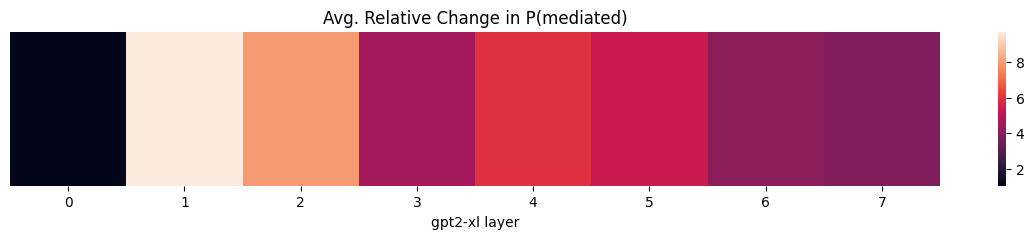

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def heatmap_by_layer(values_by_layer, title):
    plt.figure(figsize=(15, 2))
    plt.title(title)
    data = np.array([[values_by_layer[layer] for layer in sorted(values_by_layer)]])
    sns.heatmap(data)
    plt.yticks([]);
    plt.xlabel("gpt2-xl layer")

heatmap_by_layer(average_delta_by_layer, "Avg. Relative Change in P(mediated)")
plt.savefig(str(results_dir / "effect_size.png"))

# Average Mediated - Unmediated Delta

In [126]:
average_delta_diff_by_layer = {}
for layer, results in filtered_by_layer.items():
    diffs = []
    for result in results:
        before = result["before_target_mediated_score"] - result["before_target_unmediated_score"]
        after = result["after_target_mediated_score"] - result["after_target_unmediated_score"]
        if after - before < 1e-6 or before < 1e-6:
            diff = 0
        else:
            diff = after - before
        diffs.append(diff)
    if diffs:
        average_delta_diff_by_layer[layer] = sum(diffs) / len(diffs)
average_delta_diff_by_layer

-2.244140625
1.3486328125
4.828125
5.40234375
2.658203125
-3.478515625
0.056884765625
7.9453125
6.01171875
0.11236572265625
2.029296875
6.2734375
-1.9765625
3.830078125
-0.9619140625
-0.90966796875
3.94140625
2.072265625
3.59375
-1.1279296875
4.78515625
-3.12890625
0.153076171875
7.38671875
4.6640625
4.26953125
3.427734375
2.73046875
7.08203125
0.39501953125
0.60546875
-0.26953125
0.310546875
3.693359375
-3.3984375
0.9541015625
3.333984375
-0.775390625
-3.265625
-0.367431640625
-1.8154296875
2.564453125
4.15234375
-1.080078125
6.08203125
-2.2265625
5.1171875
7.30078125
0.0170440673828125
5.125
1.40625
1.5439453125
1.0302734375
4.22265625
8.28125
-1.3701171875
1.109375
5.15234375
2.724609375
6.37109375
0.59033203125
5.9296875
1.0859375
2.8203125
4.828125
2.287109375
-1.388671875
1.673828125
4.64453125
3.06640625
2.1015625
1.7724609375
5.31640625
-0.06866455078125
1.61328125
6.6953125
4.72265625
-0.468017578125
4.94921875
2.37109375
2.7109375
0.119873046875
-1.3291015625
7.59765625
0.349

{0: 0.14376458740234374,
 4: 1.5261393432617187,
 10: 0.8417088012695313,
 17: 0.2657574462890625,
 23: 0.36402874755859377,
 30: 0.37977484130859374,
 36: 0.2125316162109375,
 42: 0.17915805053710937}

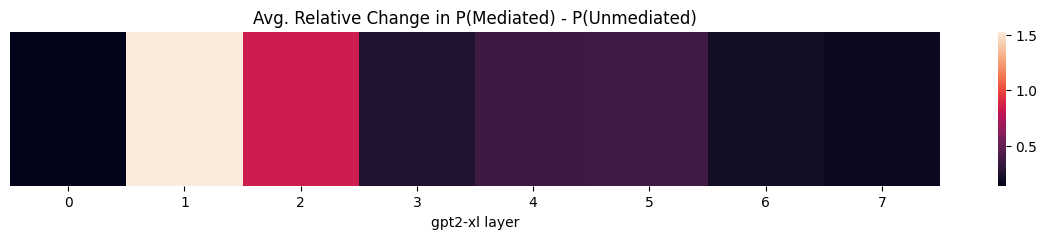

In [122]:
heatmap_by_layer(average_delta_diff_by_layer, "Avg. Relative Change in P(Mediated) - P(Unmediated)")

# Accuracy P(Med) > P(Unmediated)

In [123]:
accuracy_by_layer = {}
for layer, results in filtered_by_layer.items():
    correct = 0
    for result in results:
        if result["after_target_mediated_score"] > result["after_target_unmediated_score"]:
            correct += 1
    accuracy_by_layer[layer] = correct / len(results)
accuracy_by_layer

{0: 0.476,
 4: 0.918,
 10: 0.834,
 17: 0.55,
 23: 0.594,
 30: 0.55,
 36: 0.39,
 42: 0.31}

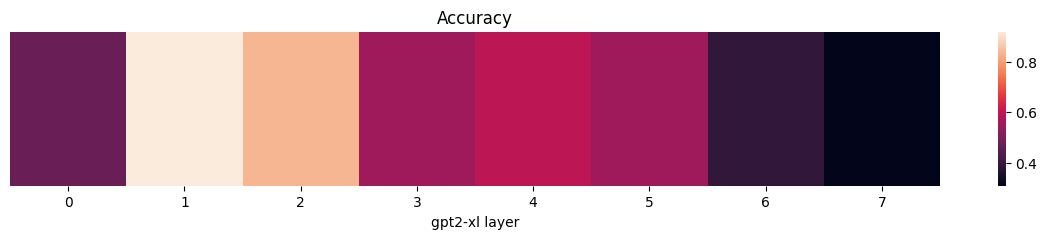

In [124]:
heatmap_by_layer(accuracy_by_layer, "Accuracy")
plt.savefig(str(results_dir / "accuracy.png"))

# HTML

In [125]:
results = [
    [results_by_layer[layer][index] for layer in results_by_layer]
    for index in range(len(results_by_layer[0]))
]
html = [
    "<!doctype html>",
    "<html>",
    "<body>",
    f'<img alt="effect_size" src="https://unitname.csail.mit.edu/context-mediation/{editor_type}/effect_size.png">',
    f'<img alt="accuracy" src="https://unitname.csail.mit.edu/context-mediation/{editor_type}/accuracy.png">',
]
for sample_num, rs in enumerate(results):
    kv = lambda key: f"<b>{key}: </b>{rs[0]['sample'][key]}"
    html += [
        "<div>",
        f"<h2>Sample {sample_num}</h2>",
        "<div>Inputs:</div>",
        "<ul>",
        f"<li>{kv('entity')}</li>",
        f"<li>{kv('context')}</li>",
        f"<li>{kv('attribute')}</li>",
        f"<li>{kv('prompt')}</li>",
        f"<li>{kv('target_mediated')}</li>",
        f"<li>{kv('target_unmediated')}</li>",
        "</ul>",
    ]
    html += [
        "<div>Model outputs:</div>",
        "<ul>",
    ]
    html += [
        "<li>",
        "<b>original: </b>",
        f"{rs[0]['before_generations']}"
        "</li>",
    ]
    for layer, result in zip(layers, rs):
        html += [
            f"<li>after edit <b>layer {layer}</b>: {result['after_generations']}</li>"
        ]
    html += [
        "</ul>",
        "<hr>",
    ]

html += [
    "</body>",
    "</html>",
]

html_file = results_dir / "editing_results.html"
html_file.parent.mkdir(exist_ok=True, parents=True)
with html_file.open("w") as handle:
    handle.write("\n".join(html))

# Playground

In [13]:
entity = "Stanford University"
attribute = "was founded in the city of Madrid"
context = f"{entity} {attribute}"
prompt = f"{entity}, located in the country of"

with editors.apply(editor, alpha=.5) as edited_mt:
    outputs = edited_mt.model.generate({
        "entity": entity,
        "prompt": prompt,
        "attribute": attribute,
        "context": context,
    }, max_new_tokens=20)
mt.tokenizer.batch_decode(outputs)

NameError: name 'editor' is not defined